In [1]:
# import wandb
# from kaggle_secrets import UserSecretsClient

# user_secrets = UserSecretsClient()
# my_secret = user_secrets.get_secret("wandb_api_key") 



In [2]:
# wandb.login(key=my_secret)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error

In [2]:
# Data Loading and Preprocessing
def load_fashion_data():
    transform_train = transforms.Compose([
        transforms.RandomCrop(28, padding=2),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.2860,), (0.3530,))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.2860,), (0.3530,))
    ])
    
    full_train = torchvision.datasets.FashionMNIST(
        root='./data', train=True, download=True, transform=None
    )
    
    # Calculate ink values for all training data
    train_size = int(0.9 * len(full_train))
    val_size = len(full_train) - train_size
    train_dataset, val_dataset = random_split(full_train, [train_size, val_size])
    
    test_dataset = torchvision.datasets.FashionMNIST(
        root='./data', train=False, download=True, transform=transform_test
    )
    
    return train_dataset, val_dataset, test_dataset, transform_train, transform_test

100%|██████████| 26.4M/26.4M [00:08<00:00, 3.05MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 74.5kB/s]
100%|██████████| 4.42M/4.42M [00:04<00:00, 1.02MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 5.47MB/s]


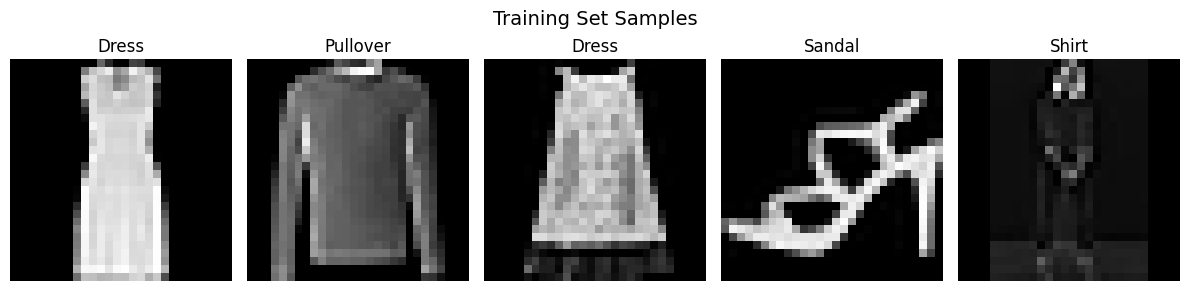

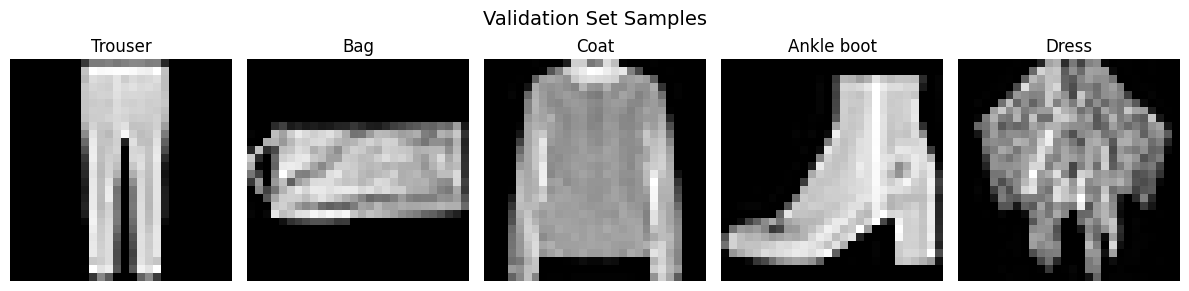

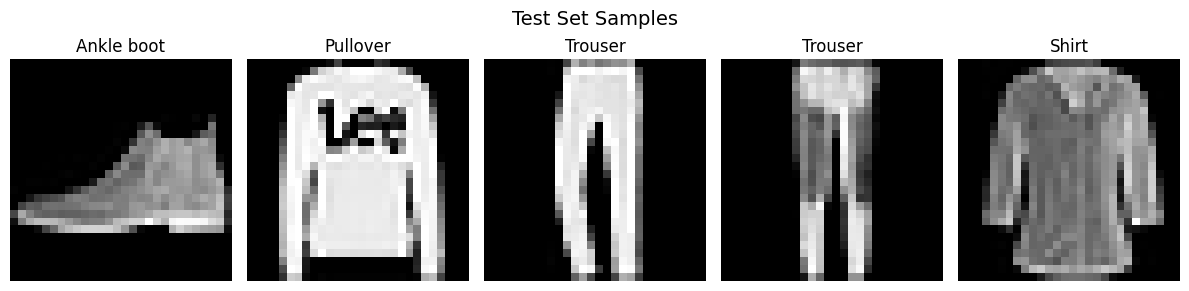

In [3]:
import matplotlib.pyplot as plt
import torchvision

# Load datasets
train_dataset, val_dataset, test_dataset, transform_train, transform_test = load_fashion_data()

# Define label names for FashionMNIST
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

def visualize_dataset_samples(dataset, title, n=5):
    fig, axes = plt.subplots(1, n, figsize=(12, 3))
    fig.suptitle(title, fontsize=14)
    
    for i in range(n):
        img, label = dataset[i]
        
        # Convert to numpy (handle both PIL and tensor)
        if isinstance(img, torch.Tensor):
            img = img.squeeze().numpy()
        else:
            img = torchvision.transforms.functional.to_tensor(img).squeeze().numpy()
        
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(class_names[label])
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize samples
visualize_dataset_samples(train_dataset, "Training Set Samples", n=5)
visualize_dataset_samples(val_dataset, "Validation Set Samples", n=5)
visualize_dataset_samples(test_dataset, "Test Set Samples", n=5)


In [4]:
class FashionMNISTDataset(Dataset):
    def __init__(self, base_dataset, transform=None):
        self.base_dataset = base_dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        if hasattr(self.base_dataset, 'dataset'):
            actual_idx = self.base_dataset.indices[idx]
            image, label = self.base_dataset.dataset[actual_idx]
        else:
            image, label = self.base_dataset[idx]
        
        # Calculate ink (mean pixel intensity before normalization)
        ink = np.array(image).mean() / 255.0
        
        if self.transform and not isinstance(image, torch.Tensor):
            image = self.transform(image)

        
        return image, label, torch.tensor(ink, dtype=torch.float32)

In [ ]:
class MultiTaskCNN(nn.Module):
    def __init__(self, num_layers=3, base_filters=32, dropout_rate=0.3):
        """
        num_layers: how many convolutional blocks to use (1-4)
        base_filters: number of filters in the first conv layer (then doubles each block)
        """
        super(MultiTaskCNN, self).__init__()

        self.convs = nn.ModuleList()
        in_channels = 1
        filters = base_filters

        # Dynamically create convolutional blocks
        for i in range(num_layers):
            block = nn.Sequential(
                nn.Conv2d(in_channels, filters, kernel_size=3, padding=1),
                nn.BatchNorm2d(filters),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
                nn.Dropout(dropout_rate)
            )
            self.convs.append(block)
            in_channels = filters
            filters *= 2  # double filters at each layer

        # Global pooling after all convs
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_channels, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 10)
        )

        # Regression head
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_channels, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1)
        )

    def forward(self, x, return_features=False):
        features = []
        for conv in self.convs:
            x = conv(x)
            if return_features:
                features.append(x.clone().detach())

        x = self.global_pool(x)
        logits = self.classifier(x)
        regression = self.regressor(x)

        if return_features:
            return logits, regression, features
        else:
            return logits, regression

In [6]:
def train_epoch(model, dataloader, optimizer, lambda1, lambda2, device):
    model.train()
    total_loss = 0
    ce_loss_total = 0
    mse_loss_total = 0
    
    ce_criterion = nn.CrossEntropyLoss()
    mse_criterion = nn.MSELoss()
    
    #pbar = tqdm(dataloader, desc='Training', leave=False)

    for images, labels, ink_targets in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        ink_targets = ink_targets.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        
        logits, ink_pred = model(images)
        
        ce_loss = ce_criterion(logits, labels)
        mse_loss = mse_criterion(ink_pred, ink_targets)
        loss = lambda1 * ce_loss + lambda2 * mse_loss
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        ce_loss_total += ce_loss.item()
        mse_loss_total += mse_loss.item()

    #pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / len(dataloader), ce_loss_total / len(dataloader), mse_loss_total / len(dataloader)

In [7]:

def evaluate(model, dataloader, lambda1, lambda2, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_ink_preds = []
    all_ink_targets = []
    total_loss = 0
    ce_loss_total = 0
    mse_loss_total = 0
    
    ce_criterion = nn.CrossEntropyLoss()
    mse_criterion = nn.MSELoss()
    
    # Add progress bar
    #pbar = tqdm(dataloader, desc='Evaluating', leave=False)
    
    with torch.no_grad():
        for images, labels, ink_targets in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            ink_targets = ink_targets.to(device).unsqueeze(1)
            
            logits, ink_pred = model(images)
            
            ce_loss = ce_criterion(logits, labels)
            mse_loss = mse_criterion(ink_pred, ink_targets)
            loss = lambda1 * ce_loss + lambda2 * mse_loss
            
            total_loss += loss.item()
            ce_loss_total += ce_loss.item()
            mse_loss_total += mse_loss.item()
            
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_ink_preds.extend(ink_pred.cpu().numpy())
            all_ink_targets.extend(ink_targets.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    mae = mean_absolute_error(all_ink_targets, all_ink_preds)
    rmse = np.sqrt(mean_squared_error(all_ink_targets, all_ink_preds))
    
    return {
        'loss': total_loss / len(dataloader),
        'ce_loss': ce_loss_total / len(dataloader),
        'mse_loss': mse_loss_total / len(dataloader),
        'accuracy': accuracy,
        'mae': mae,
        'rmse': rmse
    }

In [8]:
def train_model(config, run_name):
    wandb.init(
        project="SMAI-A4-multitask-fashion-mnist",
        config=config,
        name=run_name,
        reinit=True,
        resume=False
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load data
    train_data, val_data, test_data, transform_train, transform_test = load_fashion_data()
    train_dataset = FashionMNISTDataset(train_data, transform_train)
    val_dataset = FashionMNISTDataset(val_data, transform_test)
    test_dataset = FashionMNISTDataset(test_data, transform_test)

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

    # Model (dynamic)
    model = MultiTaskCNN(
        num_layers=config['num_layers'],
        base_filters=config['base_filters'],
        dropout_rate=config['dropout_rate']
    ).to(device)

    # Optimizer
    if config['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    elif config['optimizer'] == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'])
    else:
        optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9)

    best_val_acc = 0
    best_val_rmse = float('inf')

    # Epoch loop
    epoch_pbar = tqdm(range(config['epochs']), desc=f"λ1={config['lambda1']}, λ2={config['lambda2']}")

    for epoch in epoch_pbar:
        train_loss, train_ce, train_mse = train_epoch(
            model, train_loader, optimizer, config['lambda1'], config['lambda2'], device
        )

        val_metrics = evaluate(model, val_loader, config['lambda1'], config['lambda2'], device)

        wandb.log({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_ce_loss': train_ce,
            'train_mse_loss': train_mse,
            'val_loss': val_metrics['loss'],
            'val_ce_loss': val_metrics['ce_loss'],
            'val_mse_loss': val_metrics['mse_loss'],
            'val_accuracy': val_metrics['accuracy'],
            'val_mae': val_metrics['mae'],
            'val_rmse': val_metrics['rmse']
        })

        if val_metrics['accuracy'] > best_val_acc:
            best_val_acc = val_metrics['accuracy']
            torch.save(model.state_dict(), 'best_acc_model.pth')

        if val_metrics['rmse'] < best_val_rmse:
            best_val_rmse = val_metrics['rmse']
            torch.save(model.state_dict(), 'best_rmse_model.pth')

        epoch_pbar.set_postfix({
            'val_acc': f'{val_metrics["accuracy"]:.4f}',
            'val_rmse': f'{val_metrics["rmse"]:.4f}'
        })

    # Test evaluation
    test_metrics = evaluate(model, test_loader, config['lambda1'], config['lambda2'], device)
    wandb.log({
        'test_accuracy': test_metrics['accuracy'],
        'test_mae': test_metrics['mae'],
        'test_rmse': test_metrics['rmse']
    })

    print(f"\nTest Results: Acc={test_metrics['accuracy']:.4f}, RMSE={test_metrics['rmse']:.4f}")

    wandb.finish()
    return model, test_metrics

In [15]:
# def visualize_feature_maps(model, dataloader, device, num_images=3):
#     model.eval()
#     shown = 0
#     for images, labels, _ in dataloader:
#         images = images.to(device)
#         with torch.no_grad():
#             _, _, feature_maps = model(images, return_features=True)

#         for i in range(min(num_images, len(images))):
#             fig, axs = plt.subplots(len(feature_maps)+1, 8, figsize=(16, 2*(len(feature_maps)+1)))
#             fig.suptitle(f"Feature Maps for Test Image {i+1} (Label={labels[i].item()})", fontsize=14)

#             axs[0, 0].imshow(images[i][0].cpu(), cmap='gray')
#             axs[0, 0].set_title("Input Image")
#             for ax in axs[0, 1:]:
#                 ax.axis('off')

#             for layer_idx, fmap in enumerate(feature_maps):
#                 fmap_i = fmap[i].cpu()
#                 for j in range(8):
#                     if j < fmap_i.shape[0]:
#                         axs[layer_idx+1, j].imshow(fmap_i[j], cmap='viridis')
#                         axs[layer_idx+1, j].axis('off')
#                 axs[layer_idx+1, 0].set_ylabel(f"Layer {layer_idx+1}", rotation=0, labelpad=30)

#             plt.tight_layout()
#             plt.show()
#             shown += 1
#             if shown >= num_images:
#                 return

import matplotlib.pyplot as plt
import torch

def visualize_feature_maps(model, dataloader, device, num_images=3):
    model.eval()
    shown = 0

    for images, labels, _ in dataloader:
        images = images.to(device)
        with torch.no_grad():
            _, _, feature_maps = model(images, return_features=True)

        for i in range(min(num_images, len(images))):
            n_layers = len(feature_maps)
            n_cols = 8  # show first 8 feature maps per layer
            fig, axs = plt.subplots(n_layers + 1, n_cols, figsize=(2*n_cols, 2.2*(n_layers + 1)))
            fig.suptitle(f"Intermediate Feature Maps for Test Image {i+1} (Label = {labels[i].item()})", fontsize=14, y=1.02)

            # --- Row 1: Original Input Image ---
            axs[0, 0].imshow(images[i][0].cpu(), cmap='gray')
            axs[0, 0].set_title("Input Image", fontsize=12)
            axs[0, 0].set_ylabel("Input", fontsize=12, rotation=0, labelpad=35)
            for c in range(1, n_cols):
                axs[0, c].axis('off')

            # --- Rows 2 to N+1: Conv Block Outputs ---
            for layer_idx, fmap in enumerate(feature_maps):
                fmap_i = fmap[i].cpu()
                num_channels = fmap_i.shape[0]

                for j in range(n_cols):
                    ax = axs[layer_idx + 1, j]
                    if j < num_channels:
                        ax.imshow(fmap_i[j], cmap='viridis')
                        if layer_idx == 0:  # add column headers for first feature map row
                            ax.set_title(f"Ch {j+1}", fontsize=10)
                    else:
                        ax.axis('off')

                    ax.axis('off')

                axs[layer_idx + 1, 0].set_ylabel(
                    f"Conv Block {layer_idx + 1}",
                    fontsize=11, rotation=0, labelpad=35
                )

            plt.tight_layout()
            plt.show()

            shown += 1
            if shown >= num_images:
                return


In [44]:
# Define experiment configurations
configs = [
    {'lambda1': 1.0, 'lambda2': 1.0, 'learning_rate': 0.001, 'dropout_rate': 0.3, 'optimizer': 'Adam', 'batch_size': 128, 'epochs': 20, 'num_layers': 3, 'base_filters': 32},
    {'lambda1': 2.0, 'lambda2': 0.5, 'learning_rate': 0.001, 'dropout_rate': 0.3, 'optimizer': 'Adam', 'batch_size': 128, 'epochs': 20, 'num_layers': 3, 'base_filters': 32},
    {'lambda1': 0.5, 'lambda2': 2.0, 'learning_rate': 0.001, 'dropout_rate': 0.3, 'optimizer': 'Adam', 'batch_size': 128, 'epochs': 20, 'num_layers': 3, 'base_filters': 32},

    {'lambda1': 1.0, 'lambda2': 1.0, 'learning_rate': 0.0008, 'dropout_rate': 0.3, 'optimizer': 'Adam', 'batch_size': 64, 'epochs': 20, 'num_layers': 2, 'base_filters': 16},
    {'lambda1': 1.0, 'lambda2': 1.0, 'learning_rate': 0.0008, 'dropout_rate': 0.3, 'optimizer': 'Adam', 'batch_size': 64, 'epochs': 20, 'num_layers': 2, 'base_filters': 32},
    
    {'lambda1': 1.0, 'lambda2': 1.0, 'learning_rate': 0.0005, 'dropout_rate': 0.3, 'optimizer': 'Adam', 'batch_size': 64, 'epochs': 20, 'num_layers': 3, 'base_filters': 16},
    {'lambda1': 2.0, 'lambda2': 1.0, 'learning_rate': 0.001, 'dropout_rate': 0.3, 'optimizer': 'Adam', 'batch_size': 128, 'epochs': 20, 'num_layers': 2, 'base_filters': 32},
    {'lambda1': 1.0, 'lambda2': 2.0, 'learning_rate': 0.0008, 'dropout_rate': 0.3, 'optimizer': 'AdamW', 'batch_size': 64, 'epochs': 20, 'num_layers': 2, 'base_filters': 32},
    {'lambda1': 0.5, 'lambda2': 1.0, 'learning_rate': 0.0005, 'dropout_rate': 0.25, 'optimizer': 'AdamW', 'batch_size': 64, 'epochs': 20, 'num_layers': 3, 'base_filters': 16},
    {'lambda1': 1.0, 'lambda2': 0.5, 'learning_rate': 0.002, 'dropout_rate': 0.35, 'optimizer': 'Adam', 'batch_size': 64, 'epochs': 20, 'num_layers': 3, 'base_filters': 16}
]

results = []

for i, config in enumerate(configs, start=1):
    print(f"\n{'='*60}")
    print(f"Running experiment {i}/{len(configs)}")
    print(f"Config: λ1={config['lambda1']}, λ2={config['lambda2']}, Layers={config['num_layers']}, BaseFilters={config['base_filters']}")
    print(f"{'='*60}\n")

    run_name = f"config{i}"
    model, test_metrics = train_model(config, run_name)
    results.append({'config': config, 'metrics': test_metrics})

print("\n" + "="*70)
print("EXPERIMENT SUMMARY")
print("="*70)
for i, result in enumerate(results, start=1):
    cfg = result['config']
    print(f"\nRun {i}: λ1={cfg['lambda1']}, λ2={cfg['lambda2']}, Layers={cfg['num_layers']}, Filters={cfg['base_filters']}")
    print(f"  Test Accuracy: {result['metrics']['accuracy']:.4f}")
    print(f"  Test RMSE: {result['metrics']['rmse']:.4f}")
    print(f"  Test MAE: {result['metrics']['mae']:.4f}")



Running experiment 1/10
Config: λ1=1.0, λ2=1.0, Layers=3, BaseFilters=32



λ1=1.0, λ2=1.0: 100%|██████████| 20/20 [08:48<00:00, 26.41s/it, val_acc=0.8852, val_rmse=0.0279]



Test Results: Acc=0.8877, RMSE=0.3111


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_mae,▁
test_rmse,▁
train_ce_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_mse_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▇▇▇▇▇▇█▇▇█████
val_ce_loss,█▅▄▄▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁
val_loss,█▅▄▄▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁
val_mae,█▅▄▄▂▆▁▁▂▂▂▂▂▃▂▂▂▁▃▂



Running experiment 2/10
Config: λ1=2.0, λ2=0.5, Layers=3, BaseFilters=32



λ1=2.0, λ2=0.5: 100%|██████████| 20/20 [09:00<00:00, 27.03s/it, val_acc=0.8770, val_rmse=0.0382]



Test Results: Acc=0.8795, RMSE=0.2906


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_mae,▁
test_rmse,▁
train_ce_loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_mse_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▄▅▅▆▆▇▆▇▇█▇█████▇
val_ce_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▂
val_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▂
val_mae,▆▃▂▆▁▂█▂▃▄▃▄▃▇▅▃▄▄▆▆



Running experiment 3/10
Config: λ1=0.5, λ2=2.0, Layers=3, BaseFilters=32



λ1=0.5, λ2=2.0: 100%|██████████| 20/20 [09:02<00:00, 27.13s/it, val_acc=0.8908, val_rmse=0.0304]



Test Results: Acc=0.8884, RMSE=0.2957


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_mae,▁
test_rmse,▁
train_ce_loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_mse_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▆▅▇▇▇▇▇█▇███▇███
val_ce_loss,█▅▄▃▃▄▂▂▂▂▂▂▂▁▁▁▂▁▁▁
val_loss,█▅▄▃▃▄▂▂▂▂▂▂▂▁▁▁▂▁▁▁
val_mae,▁█▃▆▁▃▃▂▄▄▃▅▃▄▂▃▃▅▃▆



Running experiment 4/10
Config: λ1=1.0, λ2=1.0, Layers=2, BaseFilters=16



λ1=1.0, λ2=1.0: 100%|██████████| 20/20 [09:07<00:00, 27.39s/it, val_acc=0.7587, val_rmse=0.0330]



Test Results: Acc=0.7589, RMSE=0.2857


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_mae,▁
test_rmse,▁
train_ce_loss,█▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train_mse_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▄▅▆▆▆▇▇▇▇▇█▇███▇█▇
val_ce_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val_mae,▄▂▃▃█▄▁▂▄▅▅▂█▄▃▃▇▂▅▇



Running experiment 5/10
Config: λ1=1.0, λ2=1.0, Layers=2, BaseFilters=32



λ1=1.0, λ2=1.0: 100%|██████████| 20/20 [09:01<00:00, 27.07s/it, val_acc=0.8055, val_rmse=0.0212]



Test Results: Acc=0.8036, RMSE=0.3003


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_mae,▁
test_rmse,▁
train_ce_loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_mse_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▅▅▅▆▆▇▇▇▆▇▇▇█████
val_ce_loss,█▆▆▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val_loss,█▆▆▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val_mae,█▃▆▁▁▂▁▃▁▁▁▃▃▃▃▄▃▄▅▃



Running experiment 6/10
Config: λ1=1.0, λ2=1.0, Layers=3, BaseFilters=16



λ1=1.0, λ2=1.0: 100%|██████████| 20/20 [09:05<00:00, 27.27s/it, val_acc=0.8597, val_rmse=0.0379]



Test Results: Acc=0.8533, RMSE=0.2881


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_mae,▁
test_rmse,▁
train_ce_loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_mse_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▅▆▆▇▇▇▇▇▇█▇▇████
val_ce_loss,█▆▅▄▄▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁
val_loss,█▆▅▄▄▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁
val_mae,█▆▃▅▁▂▁▁▂▁▂▂▂▃▂▃▄▃▄▄



Running experiment 7/10
Config: λ1=2.0, λ2=1.0, Layers=2, BaseFilters=32



λ1=2.0, λ2=1.0: 100%|██████████| 20/20 [08:35<00:00, 25.77s/it, val_acc=0.8160, val_rmse=0.0188]



Test Results: Acc=0.8127, RMSE=0.3080


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_mae,▁
test_rmse,▁
train_ce_loss,█▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_loss,█▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_mse_loss,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇███
val_ce_loss,█▆▅▄▃▃▃▂▃▂▂▂▁▂▁▁▂▁▁▁
val_loss,█▆▅▄▃▃▃▂▃▂▂▂▁▂▁▁▂▁▁▁
val_mae,▄▄▄█▁▂▄▄▂▂▆▃▃▃▆▇▆▅▇▄



Running experiment 8/10
Config: λ1=1.0, λ2=2.0, Layers=2, BaseFilters=32



λ1=1.0, λ2=2.0: 100%|██████████| 20/20 [09:15<00:00, 27.76s/it, val_acc=0.8182, val_rmse=0.0212]



Test Results: Acc=0.8153, RMSE=0.3016


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_mae,▁
test_rmse,▁
train_ce_loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_mse_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▃▄▅▆▅▆▆▆▇▇▇▇▇▇█▇▇█
val_ce_loss,█▆▅▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁
val_loss,█▆▅▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁
val_mae,█▄▂▄▁▂▃▄▂▃▄▂▇▃▁▂▂▄▅▃



Running experiment 9/10
Config: λ1=0.5, λ2=1.0, Layers=3, BaseFilters=16



λ1=0.5, λ2=1.0: 100%|██████████| 20/20 [09:23<00:00, 28.17s/it, val_acc=0.8702, val_rmse=0.0268]



Test Results: Acc=0.8675, RMSE=0.3135


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_mae,▁
test_rmse,▁
train_ce_loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_mse_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▄▅▆▆▆▇▆▇▇▇███████
val_ce_loss,█▆▅▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
val_mae,█▄▂▃▃▂▁▂▃▃▁▂▂▁▂▁▂▃▃▃



Running experiment 10/10
Config: λ1=1.0, λ2=0.5, Layers=3, BaseFilters=16



λ1=1.0, λ2=0.5: 100%|██████████| 20/20 [09:29<00:00, 28.49s/it, val_acc=0.8642, val_rmse=0.0503]



Test Results: Acc=0.8553, RMSE=0.2792


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_mae,▁
test_rmse,▁
train_ce_loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_mse_loss,█▂▂▃▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▃▅▄▆▆▆▇▇▇▆█▇███▇█
val_ce_loss,█▆▆▆▄▅▃▃▃▂▂▂▃▁▁▁▁▁▂▁
val_loss,█▆▆▆▄▅▃▃▃▂▂▂▃▁▁▁▁▁▂▁
val_mae,▄▄▄▇█▁▅▂▇▅▆▇▄▄▄▅▇▄▃▆



EXPERIMENT SUMMARY

Run 1: λ1=1.0, λ2=1.0, Layers=3, Filters=32
  Test Accuracy: 0.8877
  Test RMSE: 0.3111
  Test MAE: 0.2896

Run 2: λ1=2.0, λ2=0.5, Layers=3, Filters=32
  Test Accuracy: 0.8795
  Test RMSE: 0.2906
  Test MAE: 0.2708

Run 3: λ1=0.5, λ2=2.0, Layers=3, Filters=32
  Test Accuracy: 0.8884
  Test RMSE: 0.2957
  Test MAE: 0.2780

Run 4: λ1=1.0, λ2=1.0, Layers=2, Filters=16
  Test Accuracy: 0.7589
  Test RMSE: 0.2857
  Test MAE: 0.2644

Run 5: λ1=1.0, λ2=1.0, Layers=2, Filters=32
  Test Accuracy: 0.8036
  Test RMSE: 0.3003
  Test MAE: 0.2789

Run 6: λ1=1.0, λ2=1.0, Layers=3, Filters=16
  Test Accuracy: 0.8533
  Test RMSE: 0.2881
  Test MAE: 0.2669

Run 7: λ1=2.0, λ2=1.0, Layers=2, Filters=32
  Test Accuracy: 0.8127
  Test RMSE: 0.3080
  Test MAE: 0.2868

Run 8: λ1=1.0, λ2=2.0, Layers=2, Filters=32
  Test Accuracy: 0.8153
  Test RMSE: 0.3016
  Test MAE: 0.2801

Run 9: λ1=0.5, λ2=1.0, Layers=3, Filters=16
  Test Accuracy: 0.8675
  Test RMSE: 0.3135
  Test MAE: 0.2925

Run 10:

Training briefly for visualization...
Epoch 1, Total: 0.8348, CE: 0.8295, MSE: 0.0053
Epoch 2, Total: 0.5820, CE: 0.5792, MSE: 0.0027
Epoch 3, Total: 0.5176, CE: 0.5152, MSE: 0.0023

Visualizing intermediate feature maps...


/tmp/ipykernel_53133/4058176140.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  ink = np.array(image).mean() / 255.0


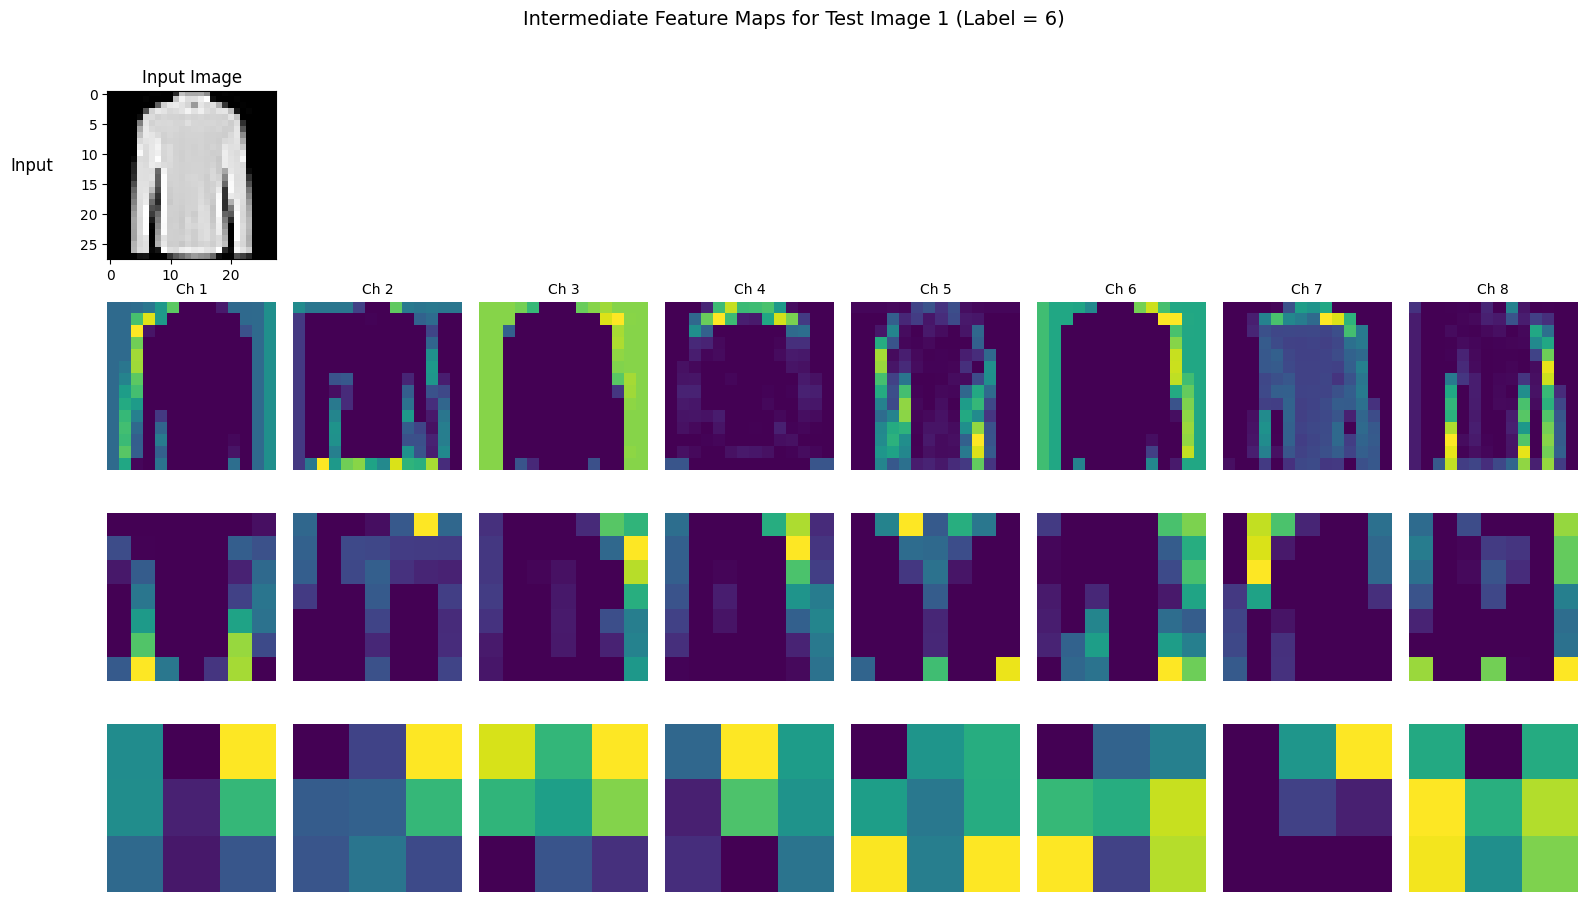

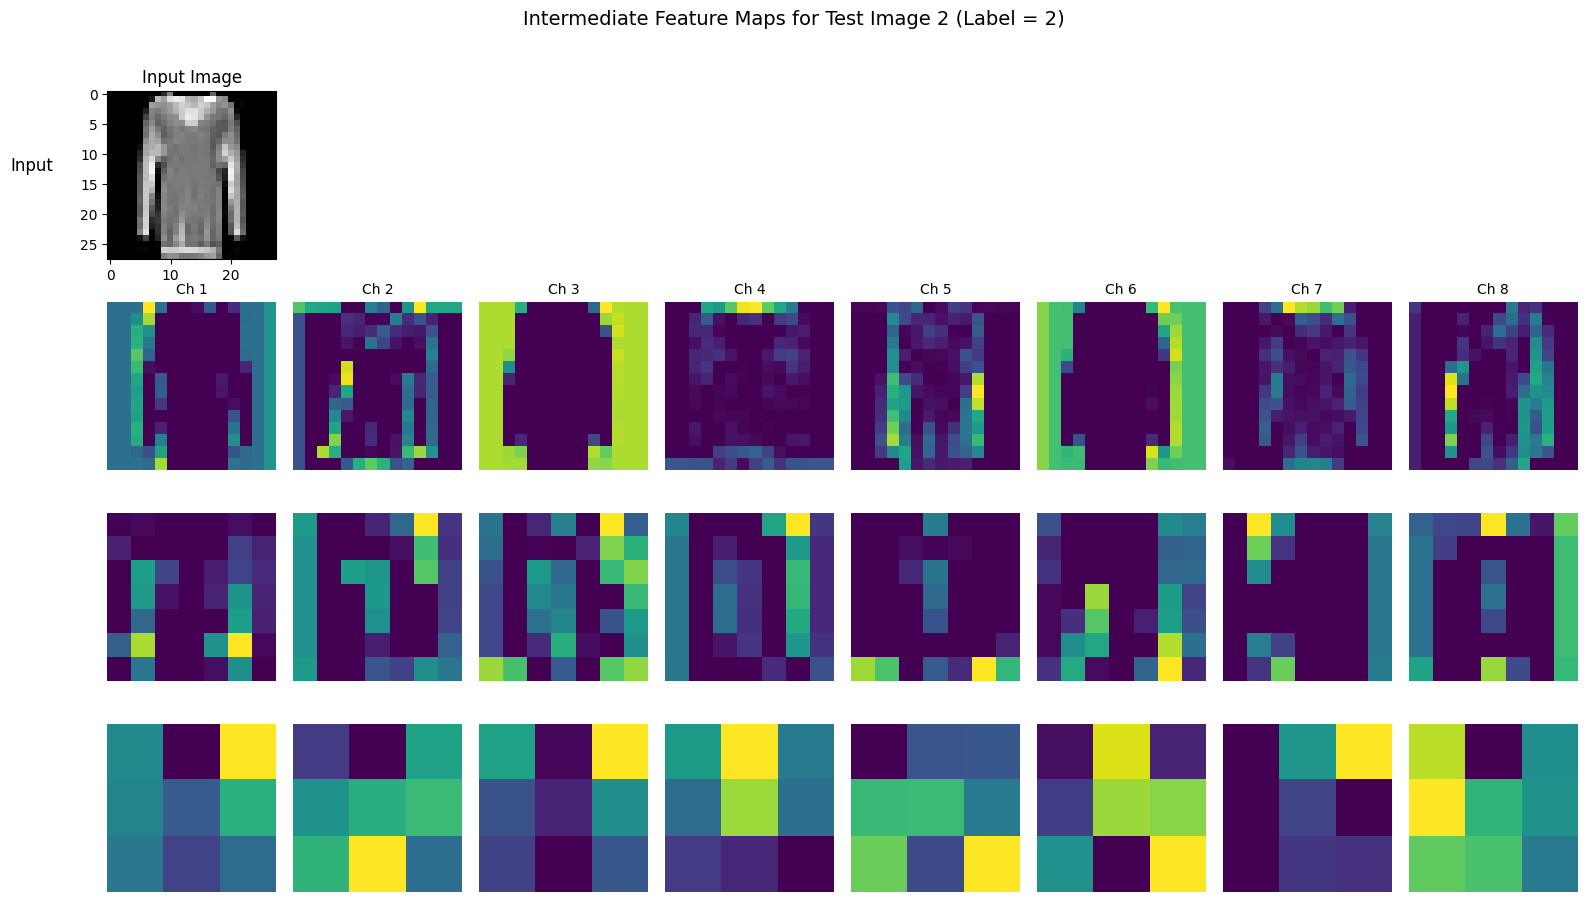

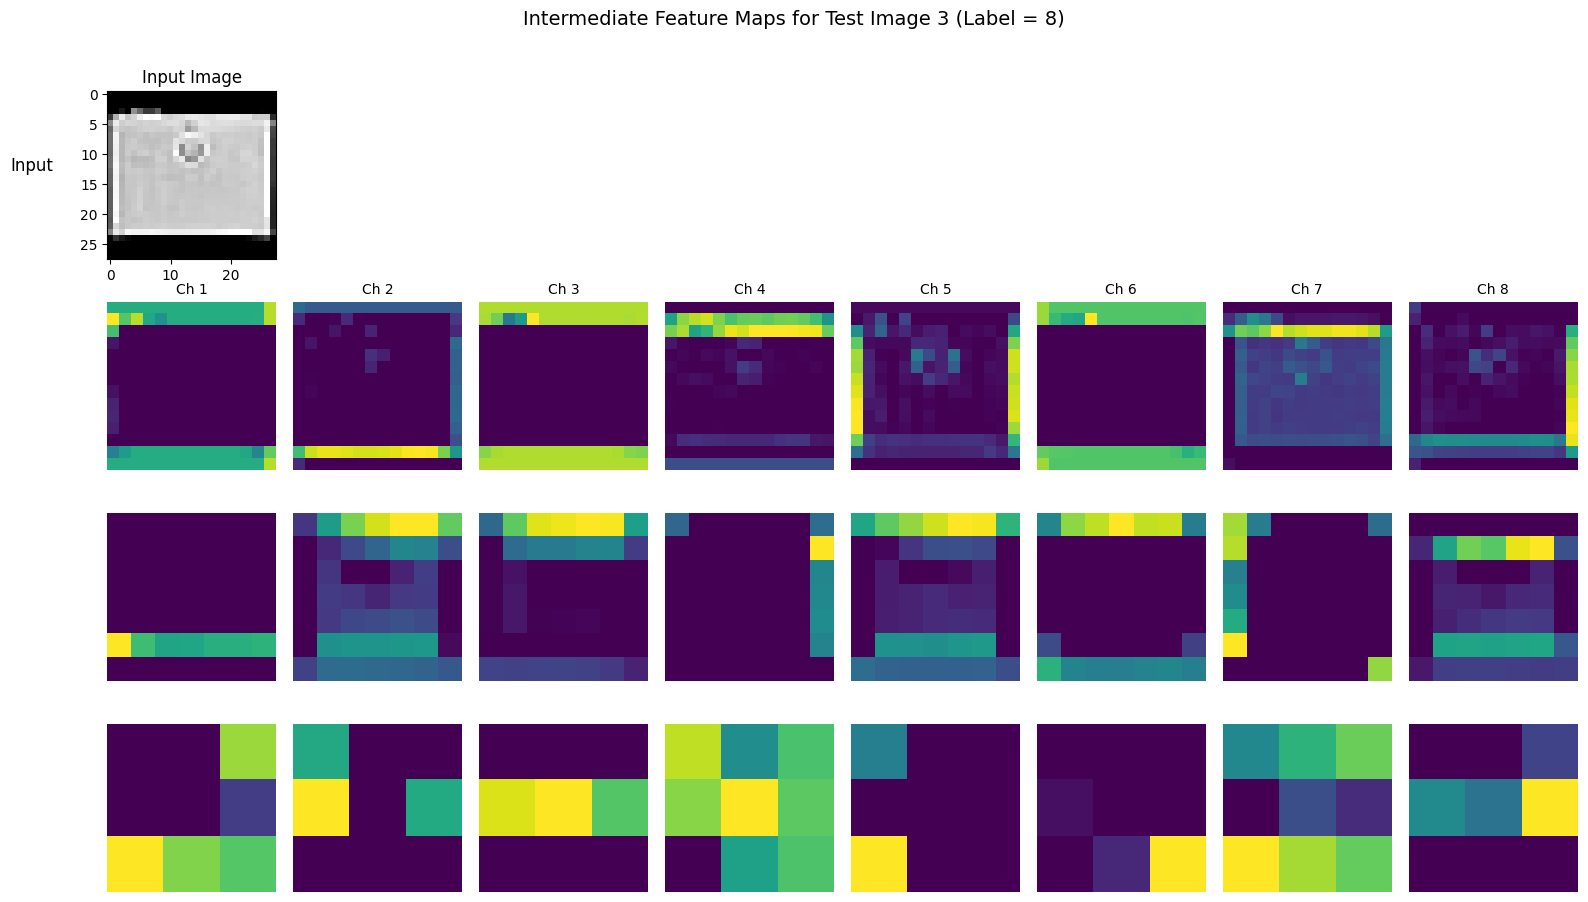

In [17]:
device = torch.device('cpu')

train_data, val_data, test_data, transform_train, transform_test = load_fashion_data()
train_dataset = FashionMNISTDataset(train_data, transform_train)
test_dataset = FashionMNISTDataset(test_data, transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

model = MultiTaskCNN(num_layers=3, base_filters=32, dropout_rate=0.25).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print("Training briefly for visualization...")
for epoch in range(3):
    train_loss, ce_loss, mse_loss = train_epoch(model, train_loader, optimizer, lambda1=1.0, lambda2=1.0, device=device)
    print(f"Epoch {epoch+1}, Total: {train_loss:.4f}, CE: {ce_loss:.4f}, MSE: {mse_loss:.4f}")


print("\nVisualizing intermediate feature maps...")
visualize_feature_maps(model, test_loader, device, num_images=3)